## Movie count predictor 

Dieses Notebook soll eine KI trainieren, welche anhand von Metainformationen über Schauspieler_innen einschätzen soll, an wie vielen Filmen diese Person bereits aktiv mitgewirkt hat. Dafür nutzen wir einen selbst bereicherten Datensatz namens *actors_imdb_enriched.csv*

In [1]:
# imports
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# open the file
actors = pd.read_csv('imdb/actors_imdb_enriched.csv')
print(actors.head())


      nconst       primaryName birthYear deathYear  \
0  nm4699627  Sturgill Simpson      1978        \N   
1  nm2903245         Rick Okon      1989        \N   
2  nm0805709      Bart Slegers        \N        \N   
3  nm2987470         Ana Rujas      1989        \N   
4  nm1508186     Park Hyo-joon      1980        \N   

               primaryProfession                             knownForTitles  \
0  music_artist,soundtrack,actor  tt5537002,tt8244784,tt11252248,tt11858890   
1                          actor    tt5830254,tt4338336,tt1830792,tt0806910   
2                          actor    tt0096961,tt0149534,tt2585160,tt0217205   
3        actress,writer,producer  tt8716014,tt20096840,tt13880448,tt6060156   
4                          actor   tt3914520,tt0821442,tt10726604,tt0390205   

   gender  birth_date death_date                                birth_place  \
0    male  1978-06-08        NaN                     Jackson, Kentucky, USA   
1    male  1989-04-13        NaN  Schwedt 

In [3]:
# get rows without any missing values except for columns with "death" in the name
actors_qual = actors.dropna(subset=[col for col in actors.columns if 'death' not in col])
print(len(actors_qual))

2910


In [4]:
# count by gender
counts = actors_qual["gender"].value_counts()
print(counts)


gender
male      1738
female    1172
Name: count, dtype: int64


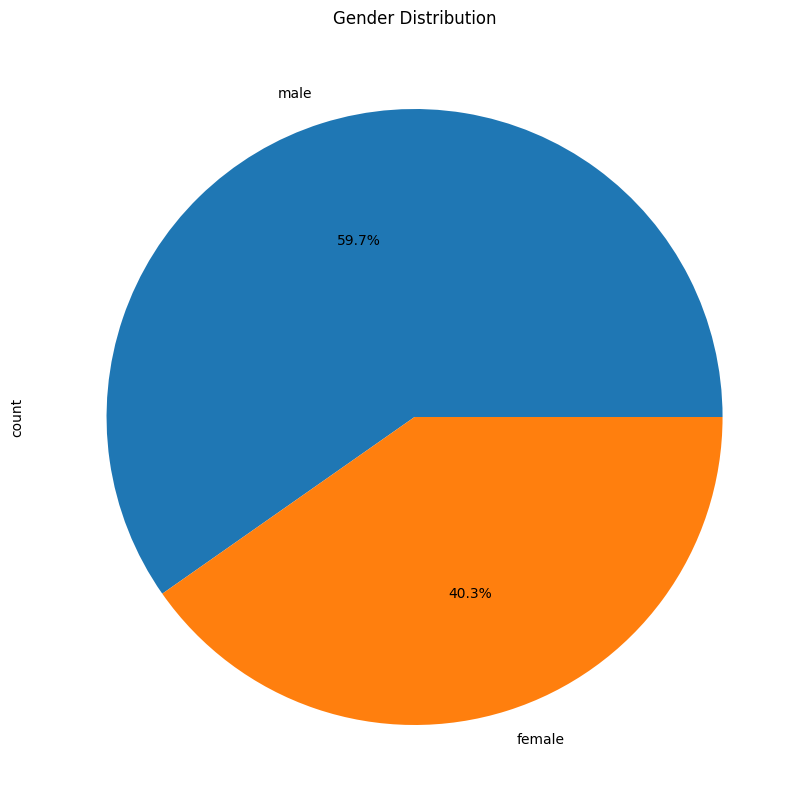

In [5]:
# as pie chart
plt.figure(figsize=(10, 10))
actors_qual["gender"].value_counts().plot.pie(autopct="%1.1f%%")
plt.title("Gender Distribution")
plt.show()

In [6]:
# add movie count by counting name occurences in the letterboxd/actors.csv file
# then add count to the actors_qual dataframe as a new column
actors_letterboxd = pd.read_csv('letterboxd/actors.csv')
actors_letterboxd = actors_letterboxd.dropna(subset=['name'])
actor_counts = actors_letterboxd['name'].value_counts()
actors_qual['movie_count'] = actors_qual['primaryName'].map(actor_counts)
print(actors_qual.head())



       nconst    primaryName birthYear deathYear  \
1   nm2903245      Rick Okon      1989        \N   
3   nm2987470      Ana Rujas      1989        \N   
4   nm1508186  Park Hyo-joon      1980        \N   
9   nm2257755  Dylan Everett      1995        \N   
11  nm1690632  Frida Farrell      1979        \N   

                   primaryProfession  \
1                              actor   
3            actress,writer,producer   
4                              actor   
9   actor,camera_department,producer   
11         actress,producer,director   

                               knownForTitles  gender  birth_date death_date  \
1     tt5830254,tt4338336,tt1830792,tt0806910    male  1989-04-13        NaN   
3   tt8716014,tt20096840,tt13880448,tt6060156  female  1989-05-14        NaN   
4    tt3914520,tt0821442,tt10726604,tt0390205    male  1980-06-12        NaN   
9     tt3891538,tt1479978,tt0288937,tt0910847    male  1995-01-24        NaN   
11    tt7148088,tt1001548,tt3390376,tt1328910 

/var/folders/mm/wg5zj6k13k13vjwk3yzfpsdc0000gn/T/ipykernel_10454/1780726028.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_qual['movie_count'] = actors_qual['primaryName'].map(actor_counts)


In [7]:
# show actors with the most movies
actors_sorted = actors_qual.copy()
actors_sorted = actors_sorted.sort_values(by='movie_count', ascending=False)
print(actors_sorted.head())

         nconst         primaryName birthYear deathYear  \
1965  nm0283170        Bess Flowers      1898      1984   
1806  nm0103977        Brahmanandam      1956        \N   
6146  nm0149822  Mithun Chakraborty      1950        \N   
4311  nm0000955           Ward Bond      1903      1960   
8961  nm0000640        Martin Sheen      1940        \N   

                         primaryProfession  \
1965                               actress   
1806     actor,music_department,soundtrack   
6146  actor,music_department,miscellaneous   
4311                      actor,soundtrack   
8961             actor,producer,soundtrack   

                               knownForTitles  gender  birth_date  death_date  \
1965  tt0019556,tt0023478,tt0026105,tt0029543  female  1898-11-23  1984-07-28   
1806  tt0471571,tt1756476,tt3142764,tt5457772    male  1956-02-01         NaN   
6146  tt1980986,tt0499375,tt2283748,tt8108268    male  1950-06-16         NaN   
4311  tt0049730,tt0045061,tt0033870,tt003865

In [8]:
# preprocess the data for prediction of the number of movies
actors_qual_prepped =actors_qual.copy()
# drop columns that are not needed
actors_qual_prepped = actors_qual_prepped.drop(columns=['death_cause','nconst','primaryProfession', 'knownForTitles', 'primaryName', 'birthYear', 'deathYear', 'death_place'])

# split birth date into year, month, day
actors_qual_prepped['birthYear'] = actors_qual_prepped['birth_date'].str.split('-', expand=True)[0]
actors_qual_prepped['birthMonth'] = actors_qual_prepped['birth_date'].str.split('-', expand=True)[1]
actors_qual_prepped['birthDay'] = actors_qual_prepped['birth_date'].str.split('-', expand=True)[2]

# drop birth date
actors_qual_prepped = actors_qual_prepped.drop(columns=['birth_date'])

# if there is no death date, fill it with 0000-00-00
actors_qual_prepped['death_date'] = actors_qual_prepped['death_date'].fillna('0000-00-00')

#split death date into year, month, day if it exists
actors_qual_prepped['deathYear'] = actors_qual_prepped['death_date'].str.split('-', expand=True)[0]
actors_qual_prepped['deathMonth'] = actors_qual_prepped['death_date'].str.split('-', expand=True)[1]
actors_qual_prepped['deathDay'] = actors_qual_prepped['death_date'].str.split('-', expand=True)[2]

# drop death date
actors_qual_prepped = actors_qual_prepped.drop(columns=['death_date'])



In [9]:
# turn dates into age
actors_qual_prepped['birthYear'] = pd.to_numeric(actors_qual_prepped['birthYear'])
actors_qual_prepped['deathYear'] = pd.to_numeric(actors_qual_prepped['deathYear'])
actors_qual_prepped['birthMonth'] = pd.to_numeric(actors_qual_prepped['birthMonth'])
actors_qual_prepped['deathMonth'] = pd.to_numeric(actors_qual_prepped['deathMonth'])
actors_qual_prepped['birthDay'] = pd.to_numeric(actors_qual_prepped['birthDay'])
actors_qual_prepped['deathDay'] = pd.to_numeric(actors_qual_prepped['deathDay'])

# if there is no death date, fill it with today's date to calculate age
actors_qual_prepped['deathYear'] = actors_qual_prepped['deathYear'].replace(0000, 2024)
actors_qual_prepped['deathMonth'] = actors_qual_prepped['deathMonth'].replace(00, 6)
actors_qual_prepped['deathDay'] = actors_qual_prepped['deathDay'].replace(00, 7)

actors_qual_prepped['age'] = actors_qual_prepped['deathYear'] - actors_qual_prepped['birthYear']
actors_qual_prepped['age'] = actors_qual_prepped['age'] + (actors_qual_prepped['deathMonth'] - actors_qual_prepped['birthMonth'])/12
actors_qual_prepped['age'] = actors_qual_prepped['age'] + (actors_qual_prepped['deathDay'] - actors_qual_prepped['birthDay'])/365

# round age to 0 decimal places
actors_qual_prepped['age'] = actors_qual_prepped['age'].round(0)

# change age to int
actors_qual_prepped['age'] = actors_qual_prepped['age'].astype(int)

# drop birth and death year, month, day
actors_qual_prepped = actors_qual_prepped.drop(columns=['birthYear', 'deathYear', 'birthMonth', 'deathMonth', 'birthDay', 'deathDay'])



In [10]:
# Split birth_place into parts
birth_place_parts = actors_qual_prepped['birth_place'].str.split(', ', expand=True)

# If there are three parts, assign them as city, state, and country
three_parts_mask = birth_place_parts[2].notna()
actors_qual_prepped.loc[three_parts_mask, 'birthCity'] = birth_place_parts.loc[three_parts_mask, 0]
actors_qual_prepped.loc[three_parts_mask, 'birthCountry'] = birth_place_parts.loc[three_parts_mask, 2]

# If there are two parts, assign them as city and country
two_parts_mask = ~three_parts_mask
actors_qual_prepped.loc[two_parts_mask, 'birthCity'] = birth_place_parts.loc[two_parts_mask, 0]
actors_qual_prepped.loc[two_parts_mask, 'birthCountry'] = birth_place_parts.loc[two_parts_mask, 1]

# Drop the original birth_place column
actors_qual_prepped = actors_qual_prepped.drop(columns=['birth_place'])

In [11]:
# show counts of each country of birth
actors_qual_prepped['birthCountry'].value_counts()

birthCountry
USA                               1125
England                            206
Japan                              171
Germany                            140
UK                                 113
                                  ... 
France [now Sour el Ghozlane         1
British India [now West Bengal       1
Thailand                             1
West Midlands                        1
Rhône-Alpes                          1
Name: count, Length: 159, dtype: int64

In [12]:
# show counts of each city of birth
actors_qual_prepped['birthCity'].value_counts()

birthCity
New York City       105
Los Angeles          75
London               59
Tokyo                54
Brooklyn             43
                   ... 
Venezia               1
Mansoura              1
Zürich                1
Eisenhüttenstadt      1
Southend              1
Name: count, Length: 1430, dtype: int64

In [13]:
# set UK and United Kingdom to England
actors_qual_prepped['birthCountry'] = actors_qual_prepped['birthCountry'].replace('UK', 'England')
actors_qual_prepped['birthCountry'] = actors_qual_prepped['birthCountry'].replace('United Kingdom', 'England')


In [14]:
# check counts again
actors_qual_prepped['birthCountry'].value_counts()

birthCountry
USA                               1125
England                            319
Japan                              171
Germany                            140
Canada                             108
                                  ... 
Nordrhein-Westfalen                  1
Turkey]                              1
Ireland [now Northern Ireland]       1
Trinidad & Tobago                    1
Rhône-Alpes                          1
Name: count, Length: 158, dtype: int64

In [15]:
# change city and country for actors born in one that has a count of less than 10 to "Other"    
actors_qual_prepped['birthCity'] = actors_qual_prepped['birthCity'].where(actors_qual_prepped['birthCity'].map(actors_qual_prepped['birthCity'].value_counts()) > 1, 'Other')
actors_qual_prepped['birthCountry'] = actors_qual_prepped['birthCountry'].where(actors_qual_prepped['birthCountry'].map(actors_qual_prepped['birthCountry'].value_counts()) > 10, 'Other')

In [16]:
# new york city is in the US
actors_qual_prepped['birthCountry'] = actors_qual_prepped['birthCountry'].replace('New York', 'USA')
print(actors_qual_prepped['birthCountry'].value_counts())


birthCountry
USA                           1172
Other                          378
England                        319
Japan                          171
Germany                        140
Canada                         108
Italy                           94
France                          61
India                           49
West Germany                    42
Finland                         36
Austria                         32
Mexico                          32
Australia                       31
Spain                           26
Brazil                          24
Sweden                          23
South Korea                     21
Poland                          20
German Democratic Republic      17
Ireland                         16
Netherlands                     16
China                           15
Switzerland                     15
Turkey                          14
Portugal                        14
Denmark                         12
Argentina                       12
Name: c

In [17]:
print(actors_qual_prepped['birthCity'].value_counts())

birthCity
Other            1079
New York City     105
Los Angeles        75
London             59
Tokyo              54
                 ... 
Stettin             2
Southport           2
Huntington          2
Urbana              2
Yakima              2
Name: count, Length: 352, dtype: int64


In [18]:
# because there are too many cities, we will only keep the country
actors_qual_prepped = actors_qual_prepped.drop(columns=['birthCity'])

In [19]:
# turn height into a number
actors_qual_prepped['height'] = pd.to_numeric(actors_qual_prepped['height'].str.replace(' m', ''))

# turn birthYear, birthMonth, birthDay, deathYear, deathMonth, deathDay into numbers


In [20]:
# now we can make the columns except for "nconst" categorical and one-hot encode them
actors_qual_prepped_dm = pd.get_dummies(actors_qual_prepped)
print(actors_qual_prepped_dm.head())



    height  movie_count  age  gender_female  gender_male  \
1     1.82           14   35          False         True   
3     1.72           15   35           True        False   
4     1.80           17   44          False         True   
9     1.69           17   29          False         True   
11    1.74           12   44           True        False   

    birthCountry_Argentina  birthCountry_Australia  birthCountry_Austria  \
1                    False                   False                 False   
3                    False                   False                 False   
4                    False                   False                 False   
9                    False                   False                 False   
11                   False                   False                 False   

    birthCountry_Brazil  birthCountry_Canada  ...  birthCountry_Other  \
1                 False                False  ...               False   
3                 False             

In [21]:
# get the average movie count for male vs female actors
average_movie_count_male = actors_qual_prepped_dm[actors_qual_prepped_dm['gender_male'] == True]['movie_count'].mean()
average_movie_count_female = actors_qual_prepped_dm[actors_qual_prepped_dm['gender_male'] == False]['movie_count'].mean()
print(average_movie_count_male)
print(average_movie_count_female)


42.42807825086306
32.82679180887372


In [28]:
# let's check the correlation between the columns
correlation = actors_qual_prepped_dm.corr()
print(correlation)

                                           height  movie_count       age  \
height                                   1.000000     0.045788  0.040022   
movie_count                              0.045788     1.000000  0.256446   
age                                      0.040022     0.256446  1.000000   
gender_female                           -0.662864    -0.126820 -0.084956   
gender_male                              0.662864     0.126820  0.084956   
birthCountry_Argentina                   0.006164    -0.010360  0.042449   
birthCountry_Australia                  -0.006705    -0.018787 -0.048997   
birthCountry_Austria                     0.010423    -0.014195  0.026675   
birthCountry_Brazil                     -0.012752    -0.040469 -0.030429   
birthCountry_Canada                      0.054966    -0.001009 -0.070354   
birthCountry_China                      -0.014628     0.030576 -0.027485   
birthCountry_Denmark                     0.040673    -0.030434 -0.018915   
birthCountry

height                                    -0.034751
movie_count                               -0.179548
age                                       -0.321399
gender_female                              0.087783
gender_male                               -0.087783
birthCountry_Argentina                     0.726291
birthCountry_Australia                     0.562715
birthCountry_Austria                       0.555817
birthCountry_Brazil                        0.614560
birthCountry_Canada                        0.190834
birthCountry_China                         0.694374
birthCountry_Denmark                       0.726291
birthCountry_England                      -0.391946
birthCountry_Finland                       0.529270
birthCountry_France                        0.389599
birthCountry_German Democratic Republic    0.674883
birthCountry_Germany                       0.079823
birthCountry_India                         0.452049
birthCountry_Ireland                       0.684473
birthCountry

In [29]:
# get the correlation of the movie count with the other columns sorted by the absolute value of the correlation
movie_count_correlation = correlation['movie_count'].sort_values(key=lambda x: abs(x), ascending=False)
print(movie_count_correlation)

movie_count                                1.000000
age                                        0.256446
gender_male                                0.126820
gender_female                             -0.126820
birthCountry_India                         0.067650
height                                     0.045788
birthCountry_Other                        -0.040801
birthCountry_Brazil                       -0.040469
birthCountry_South Korea                  -0.039667
birthCountry_USA                           0.036161
birthCountry_Japan                         0.034356
birthCountry_China                         0.030576
birthCountry_Denmark                      -0.030434
birthCountry_Sweden                       -0.026119
birthCountry_Netherlands                  -0.025905
birthCountry_Turkey                       -0.019375
birthCountry_Portugal                     -0.019107
birthCountry_Australia                    -0.018787
birthCountry_Finland                      -0.018604
birthCountry

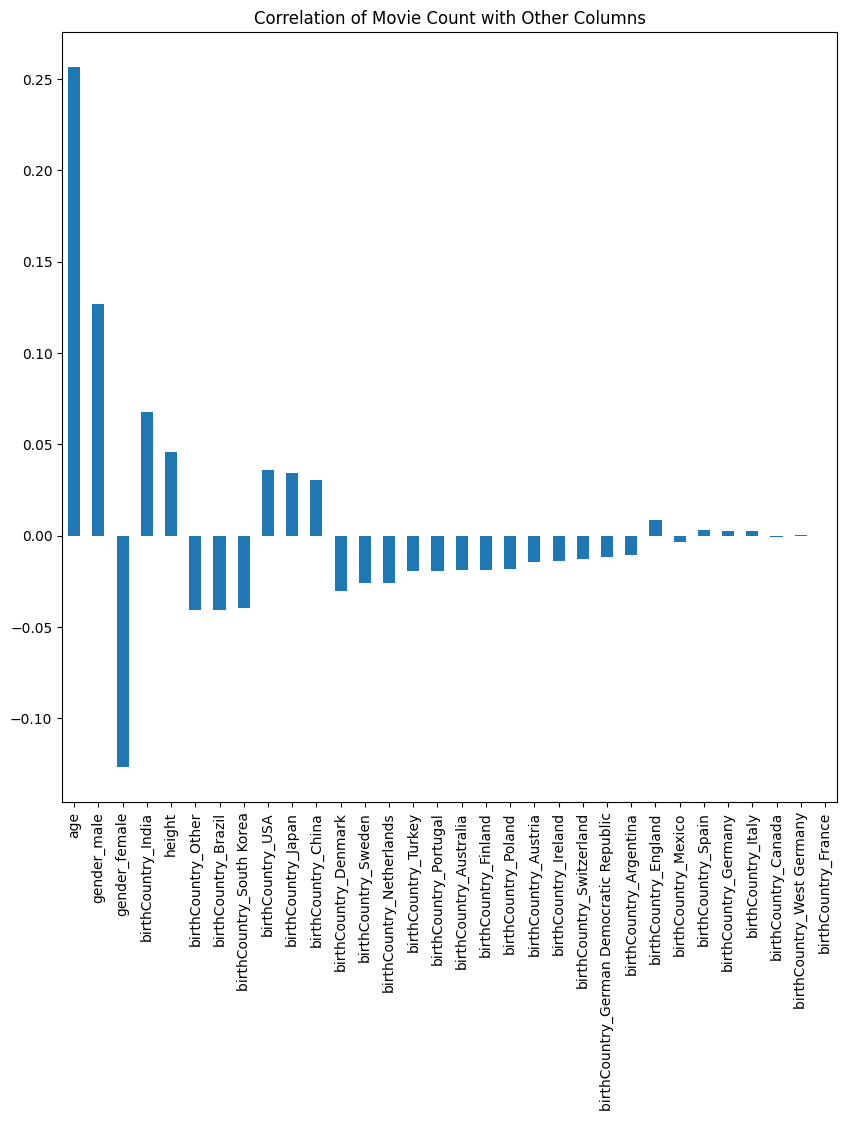

In [30]:
# lets plot the correlation of the movie count with the other columns, but combine the birthCountry columns
plt.figure(figsize=(10, 10))
movie_count_correlation[1:].plot(kind='bar')
plt.title("Correlation of Movie Count with Other Columns")
plt.show()


1421.0639052619679


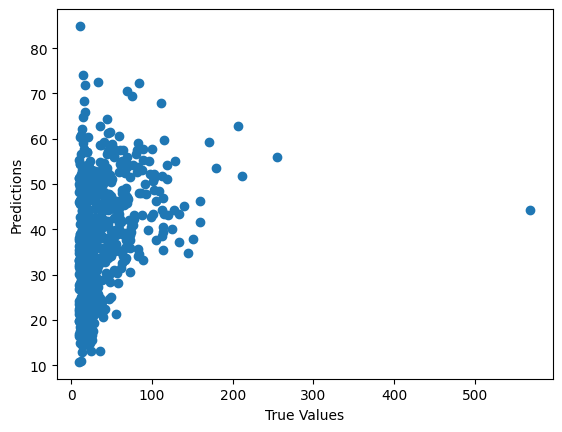

In [23]:
# now we can predict the number of movies
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# split the data
X = actors_qual_prepped_dm.drop(columns=['movie_count'])
y = actors_qual_prepped_dm['movie_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train the model
model = LinearRegression()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
mse = mean_squared_error(y_test, y_pred)
print(mse)

# plot the predictions
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()



1785.388877032443


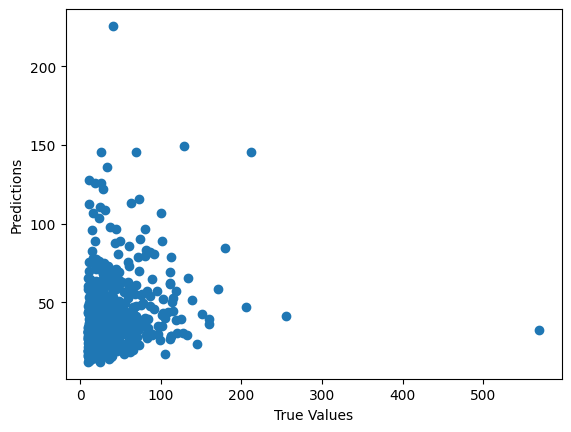

In [24]:
# try a different model
from sklearn.ensemble import RandomForestRegressor

# train the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
mse = mean_squared_error(y_test, y_pred)
print(mse)

# plot the predictions
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()


1441.701388218085


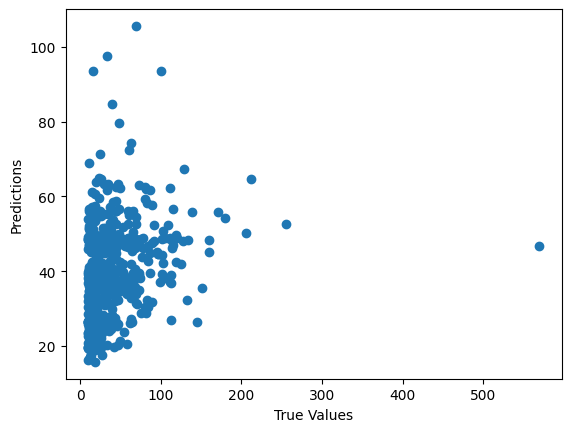

In [25]:
# try a different model
from sklearn.ensemble import GradientBoostingRegressor

# train the model
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

# evaluate
mse = mean_squared_error(y_test, y_pred)
print(mse)

# plot the predictions
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

In [26]:
# optimize the models with hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}
model = RandomForestRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)


{'max_depth': 10, 'n_estimators': 100}
1541.6020868886715


In [27]:
# Gradient Boosting
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}
model = GradientBoostingRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
model = grid_search.best_estimator_
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)


{'max_depth': 3, 'n_estimators': 50}
1421.3828620343827


In [41]:
# try out all models for two made up actors with only gender as the difference

# get a random actor from the test set
actor = X_test.sample(1)
print("Height:" + str(actor['height'].values[0]))
print("Age:" + str(actor['age'].values[0]))

# make a copy of the actor
actor2 = actor.copy()

# set the gender
actor["gender_female"] = False
actor["gender_male"] = True

actor2["gender_female"] = True
actor2["gender_male"] = False

# predict the number of movies
print("Male prediction: " + str(model.predict(actor).round(0).astype(int)))
print("Female prediction: " + str(model.predict(actor2).round(0).astype(int)))


Height:1.68
Age:46
Male prediction: [27]
Female prediction: [26]


In [48]:
# try it 50 times and see the average
avg_male = 0
avg_female = 0
for i in range(50):
    actor = X_test.sample(1)
    actor2 = actor.copy()
    # set the gender
    actor["gender_female"] = False
    actor["gender_male"] = True

    actor2["gender_female"] = True
    actor2["gender_male"] = False

    pred_male = model.predict(actor).round(0).astype(int)
    pred_female = model.predict(actor2).round(0).astype(int)

    avg_male += pred_male
    avg_female += pred_female

avg_male = avg_male / 50
avg_female = avg_female / 50

print("Average male prediction: " + str(avg_male))
print("Average female prediction: " + str(avg_female))


    

Average male prediction: [41.38]
Average female prediction: [35.06]
